# Описание проекта

Совместно с отделом маркетинга был подготовлен список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.
 
Файл `/datasets/hypothesis.csv` содержит данные о гипотезах:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Файл `/datasets/orders.csv` содержит информацию о заказах:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv` содержит информацию о разбивке на группы:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

# Итоги

Проведена приоритизация гипотез по фреймворкам ICE и RICE. Проведен анализ результатов A/B-теста, построены графики кумулятивной выручки, среднего чека, конверсии по группам. Посчитана статистическую значимость различий конверсий и средних чеков по сырым и очищенным данным. На основании анализа было принято решение о нецелесообразности дальнейшего проведения теста.

# Содержание

1. [Изучение и подготовка данных](#header_1)
2. [Приоритизация гипотез](#header_2)
    * [ICE](#header_2_1)
    * [RICE](#header_2_2)
3. [Анализ A/B-теста](#header_3)
4. [Анализ A/B-теста по очищенным данным](#header_5)
5. [Вывод](#header_4)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Изучение и подготовка данных <a id="header_1"></a>

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']
pd.options.display.max_colwidth = 150
hypothesis.info()
display(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
orders = pd.read_csv('/datasets/orders.csv')
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()
display(orders)
print("Количество полных дублей:", orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Количество полных дублей: 0


In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()
display(visitors)
print("Количество полных дублей:", visitors.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Количество полных дублей: 0


In [5]:
# проверка на попадение пользователей в обе группы
ordersA = orders[orders['group'] == 'A'][['visitor_id', 'group']].drop_duplicates()
ordersB = orders[orders['group'] == 'B'][['visitor_id', 'group']].drop_duplicates()
ordersA.merge(ordersB, on = 'visitor_id')['visitor_id'].count()


58

Привели названия колонок к удобному виду, даты привели к типу `datetime`. Пропуски в данных отсутствуют. Полные дубли отсутствуют. Необходимо проинформировать коллег о сбоях в семплировании: есть 58 пользователей, которые оказались в обеих группах.

# Приоритизация гипотез <a id="header_2"></a>

## ICE <a id="header_2_1"></a>

---

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

---

In [6]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


## RICE <a id="header_2_2"></a>

In [7]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


## Вывод
При применении двух разных фреймворков для приоритезации гипотез получили разные результаты.
В тройку лидеров и там и там попали две гипотезы: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Лидером по ICE стала гипотеза "Запустить акцию, дающую скидку на товар в день рождения", но по RICE она только на пятом месте. 

Почему так получилось? Фреймфорк RICE — это по сути маштабированный ICE: здесь учитываются все те же параметры, а еще рассматривается охват аудитории, на которую произойдет влияние. 
Если предположить, что в компании принята шкала линейной оценки гипотезы от 0 до 10, где 0 — «охват гипотезы ни на кого не повлияет», а 10 — «гипотеза охватит хотя бы половину пользователей», то для гипотезы "Запустить акцию, дающую скидку на товар в день рождения" охват пользователей составит всего 5%, а для "Добавить форму подписки на все основные страницы" — 50% и выше.



# Анализ A/B-теста <a id="header_3"></a>

### График кумулятивной выручки по группам


In [8]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [9]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (
    datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'transaction_id' : pd.Series.nunique, 
                 'visitor_id' : pd.Series.nunique, 
                 'revenue' : 'sum'}), 
           axis=1)
    .sort_values(by=['date','group']) 
)


In [10]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                      .agg({'date' : 'max', 
                            'group' : 'max', 
                            'visitors' : 'sum'}), 
                      axis=1)
    .sort_values(by=['date','group']) 
)


In [11]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head() 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


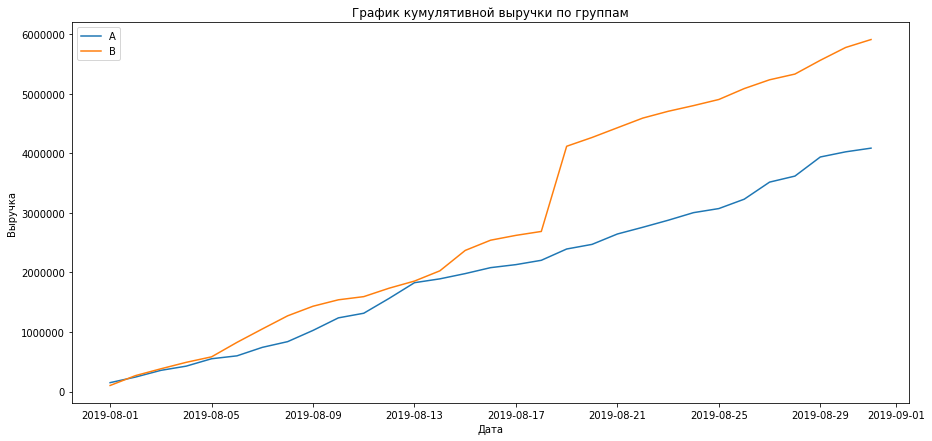

In [12]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 7))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()


В течение теста выручка увеличивается почти равномерно. После 17 августа кумулятивная выручка группы B выше, чем выручка группы А. Но, судя по характеру графика, в середине теста был совершен заказ на большую сумму пользователем из группы B (или большое количество небольших заказов). Эти заказы влияют на результаты сравнения. Возможно, без них не было бы такого разрыва в выручке между группами.


### График кумулятивного среднего чека по группам 

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

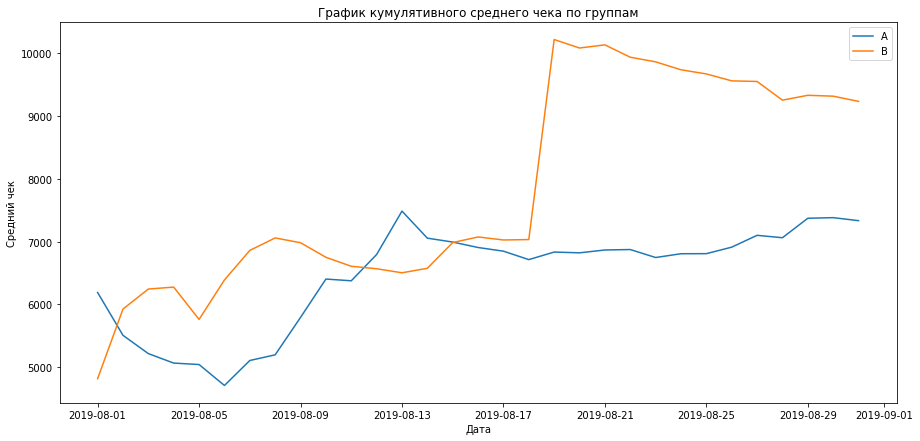

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

Похоже, что для группы A установилось значение среднего чека. При этом из-за всплеска активности в группе B в середине теста сложно сказать, установилось или нет значение. Возможно, тест требуется продлить (или исключить аномальные заказы). Вид графика группы В после 19.08 — это так называемое "возвращение к среднему". Очень характерно для единоразовых мощных выбросов.

### График относительного изменения кумулятивного среднего чека группы B к группе A 


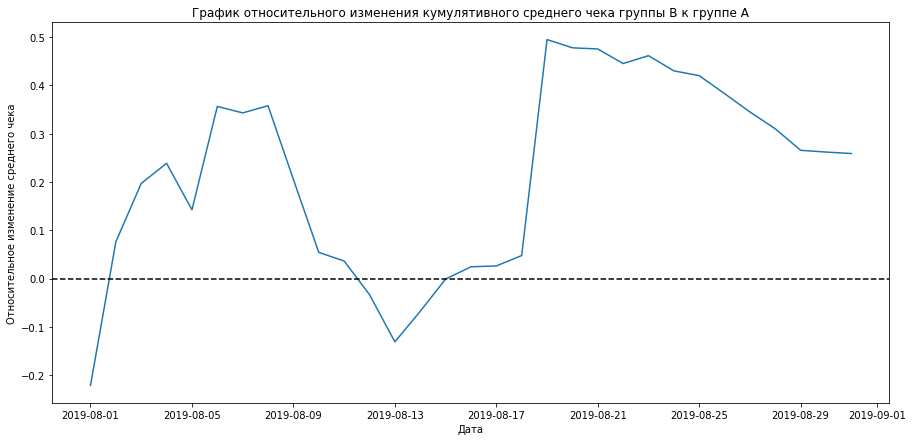

In [14]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(15, 7))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/\
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека')
plt.show()

Нет явновыраженного поведения на графике изменения среднего кумулятивного чека. В нескольких точках график различия между сегментами «скачет».

### График кумулятивной конверсии по группам


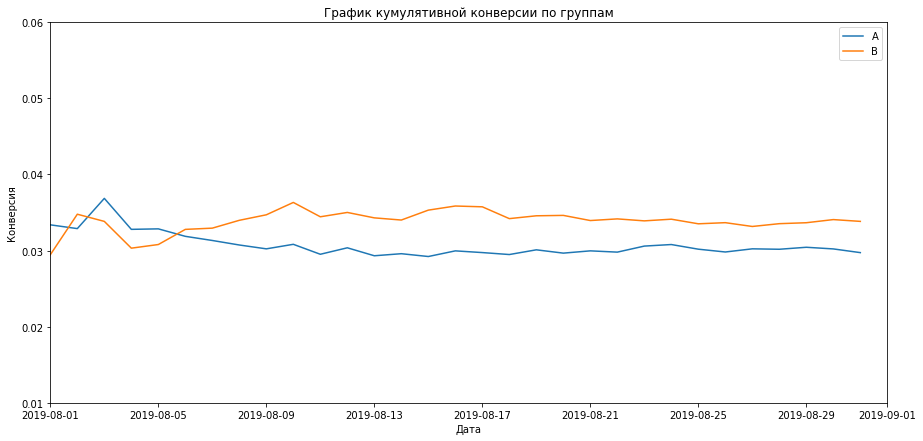

In [15]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 7))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0.01, 0.06]) 
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

В начале теста конверсия группы A и B резко колебались, к концу теста окончательно разошлись. И хотя разница между группами меньше 0.01, каждая группа заняла свою ярко выраженную позицию.
График выше — очень хорошая иллюстрация того, что делать поспешные выводы, до того как кумулятивные метрики "успокоятся", не стоит. Если бы бизнес дал нам всего 6 - 7 дней на это исследование, то результат был бы крайне сомнительный.
После 18.08 метрика относительно стабилизировалась.

### График относительного изменения кумулятивной конверсии группы B к группе A 


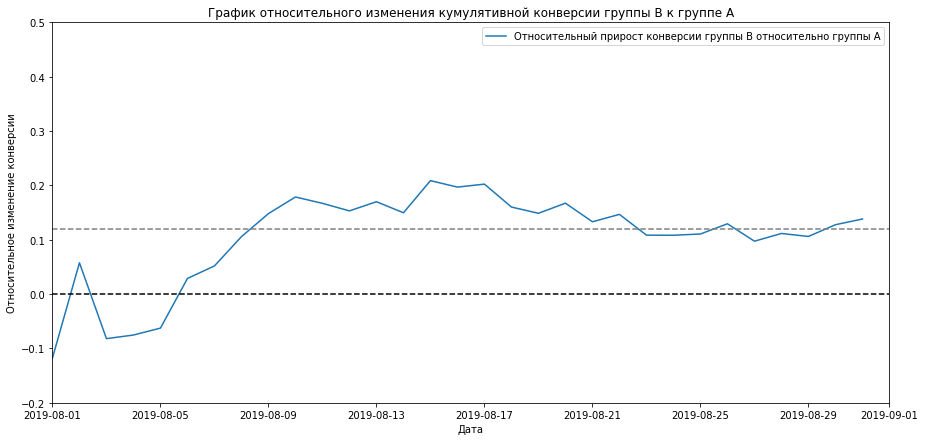

In [16]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])

# строим графики
plt.figure(figsize=(15, 7))

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.12, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.5]) 
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение конверсии')
plt.show()

Практически с самого начала теста группа B выигрывала у группы А по конверсии пользователей. Относительная конверсия росла, затем немного уменьшилась и зафиксировалась на уровне 12%.

### Точечный график количества заказов по пользователям

In [17]:
ordersByUsers = orders.groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsers.columns = ['visitor_id','orders']
ordersByUsers.sort_values(by='orders',ascending=False)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
...,...,...
359,1484903144,1
360,1485964287,1
361,1494664757,1
362,1495112755,1


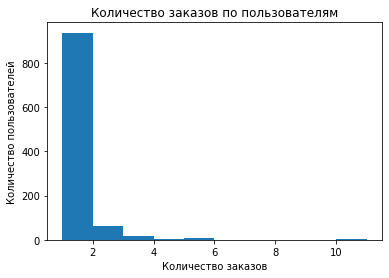

In [18]:
plt.hist(ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

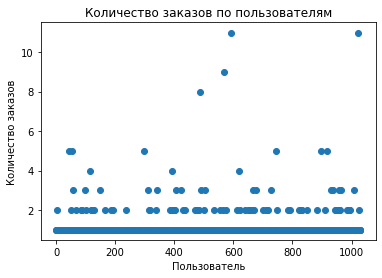

In [19]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователь')
plt.ylabel('Количество заказов')
plt.show()

В основном на пользователя приходится 1-2 заказа. Число заказов больше трех можно считать аномалией.

### Расчет 95-й и 99-й перцентили количества заказов на пользователя. 
Выбор границы для определения аномальных пользователей.


In [20]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


Не более 5% пользователей делают больше двух заказов, не более 1% — более 4 заказов. Можно установаиь границу 3 заказа.

### Точечный график стоимостей заказов



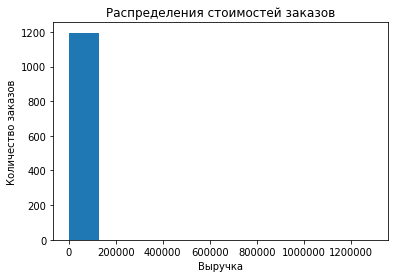

In [21]:
plt.hist(orders['revenue'])
plt.title('Распределения стоимостей заказов')
plt.xlabel('Выручка')
plt.ylabel('Количество заказов')
plt.show()

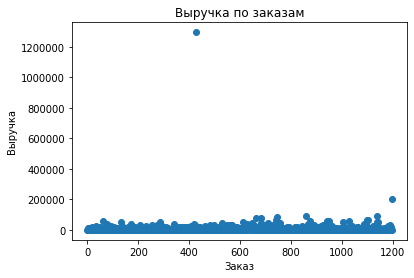

In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Выручка по заказам')
plt.xlabel('Заказ')
plt.ylabel('Выручка')
plt.show()

Есть аномальные заказы, которые стоит исключить для более точного составления выводов по тесту.

### Расчет 95-й и 99-й перцентилей стоимости заказов
Выбор границы для определения аномальных заказов.


In [23]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Не более 5% заказов было сделано на сумма больше 28000 руб., не более 1% — на сумму более 58233 рублей. Можно установить границу на уровне 58000 руб.

### Cтатистическая значимость различий в конверсии между группами по «сырым» данным

Для того, чтобы сделать вывод о результатах теста, необходимо оценить стат.значимость различий. 
Гипотезы в данном случае звучат так: 
- **H0**: Конверсия в группе А и группе В одинаковая (нововведение не оказывает влияния)
- **H1**: Конверсии группы А и группы В различаются (нововведение оказывет влияние) 
    


Посчитаем статистическую значимость различия в конверсии между группами.
Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `['visitor_id', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.


In [24]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders'] 

Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.


In [25]:
sampleA = pd.concat([ordersByUsersA['orders'],
                      pd.Series(0, 
                                index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                name='orders')],
                    axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, 
                               index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                               name='orders')],
                    axis=0) 

alpha = 0.05
pvalue = stats.mannwhitneyu(sampleA, sampleB)[1]

print("p-value: {0:.3f}".format(pvalue))
print("Относительный изменение конверсии группы B к группе A: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

if (stats.mannwhitneyu(sampleA, sampleB)[1] < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.008
Относительный изменение конверсии группы B к группе A: 0.138
Отвергаем нулевую гипотезу: разница статистически значима


Получили статистически значимые результаты: нулевую гипотезу (о том, что между выборками нет разницы) отвергаем. Выборки различны по своему поведению. Конверсия в группе B выше, чем в группе A.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 


Гипотезы в данном случае звучат так: 
- **H0**: Средний чек в группе А и группе В одинаковый (нововведение не оказывает влияния)
- **H1**: Средние чеки в группе А и группе В различаются (нововведение оказывает влияние)
    


In [26]:
alpha = 0.05
pvalue = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
relativeChange = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1 

print("p-value: {0:.3f}".format(pvalue))
print("Относительное изменение среднего чека группы B к группе A: {0:.3f}".format(relativeChange))

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.365
Относительное изменение среднего чека группы B к группе A: 0.259
Не получилось отвергнуть нулевую гипотезу


P-value значительно больше 0,05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом среднй чек выше в группе B.

**Почему разница в конверсии 13.8% статистически значима, а разница в среднем чеке 25.9% — нет?**

Конверсия изменилась на 13.8%: в группе B появилось большое количество одинаковых значений, которые не оказывают сильного влияния на среднее значение, но при этом смещают элементы выборки относительно элементов выборки группы A.

В среднем чеке не произошло значительных изменений, а относительное различие между группами объясняется аномальным заказом. Ниже, в тесте с чистыми данными, видно что различие по среднему чеку отрицательное (B к A), то есть среднй чек больше в группе A.

In [27]:
# для ответа на вопрос значимости разницы 
display(stats.mannwhitneyu(sampleA, sampleB))
display(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue']))
display(sampleA.value_counts())
display(sampleB.value_counts())

MannwhitneyuResult(statistic=176473106.0, pvalue=0.008396177528376304)

MannwhitneyuResult(statistic=176175.0, pvalue=0.3646454927716229)

0    18233
1      473
2       17
3        7
4        3
5        2
7        1
Name: orders, dtype: int64

0    18330
1      552
2       23
3        5
4        4
6        1
5        1
Name: orders, dtype: int64

# Анализ A/B теста по очищенным данным <a id = 'header_5'></a>

Найденные выше 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 58 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и 1% пользователей с дорогими заказами.

In [28]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitor_id'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 3]['visitor_id']], 
                                axis = 0)

usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitor_id']

abnormalUsers = pd.concat([usersWithManyOrders, 
                           usersWithExpensiveOrders], 
                          axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head())
abnormalUsers.shape


1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
Name: visitor_id, dtype: int64

(20,)

Всего 20 аномальных пользователей. 
Отфильтуем аномальные данные


In [29]:
sampleAFiltered=pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],
                           pd.Series(0, 
                                     index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                     name='orders')],
                            axis=0)


sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, 
                                       index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],
                            axis=0) 


### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Гипотезы в данном случае звучат так: 
- **H0**: Конверсия в группе А и группе В одинаковая (нововведение не оказывает влияния)
- **H1**: Конверсии группы А и группы В различаются (нововведение оказывет влияние) 

In [30]:
alpha = 0.05
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Относительный изменение конверсии группы B к группе A: {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

if (stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.007
Относительный изменение конверсии группы B к группе A: 0.151
Отвергаем нулевую гипотезу: разница статистически значима


Получили статистически значимые результаты: нулевую гипотезу (о том, что между выборками нет разницы) отвергаем. Выборки различны по своему поведению. Коверсия в группе B выше, чем в группе A.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным



Гипотезы в данном случае звучат так: 
- **H0**: Средний чек в группе А и группе В одинаковый (нововведение не оказывает влияния)
- **H1**: Средние чеки в группе А и группе В различаются (нововведение оказывает влияние)

In [31]:
alpha = 0.05
pvalue = stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]

filtredOrdersA = orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]
filtredRevenueMeanA = filtredOrdersA['revenue'].mean()
filtredOrdersB = orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]
filtredRevenueMeanB = filtredOrdersB['revenue'].mean()

relativeChange = filtredRevenueMeanB/filtredRevenueMeanA - 1

print("p-value: {0:.3f}".format(pvalue))
print("Относительное изменение среднего чека группы B к группе A: {0:.3f}".format(relativeChange)) 

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.479
Относительное изменение среднего чека группы B к группе A: -0.014
Не получилось отвергнуть нулевую гипотезу


P-value больше 0,05, нулевую гипотезу отвергнуть не можем. Разницы в среднем чеке нет. При этом средний чек в группе B по очищенным данным меньше, чем в группе A — картина обратная тому, что наблюдали на "сырых" данных.

Построим графики для очищенных данных

In [32]:
ordersFiltered = orders[np.logical_not(orders['visitor_id'].isin(abnormalUsers))]

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (
    datesGroups
    .apply(lambda x: ordersFiltered[np.logical_and(ordersFiltered['date'] <= x['date'], ordersFiltered['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'transaction_id' : pd.Series.nunique, 
                 'visitor_id' : pd.Series.nunique, 
                 'revenue' : 'sum'}), 
           axis=1)
    .sort_values(by=['date','group']) 
)

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                      .agg({'date' : 'max', 
                            'group' : 'max', 
                            'visitors' : 'sum'}), 
                      axis=1)
    .sort_values(by=['date','group']) 
)

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head() 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,19,19,78258,713
2,2019-08-02,A,43,37,236601,1338
3,2019-08-02,B,42,41,240301,1294
4,2019-08-03,A,67,61,349074,1845


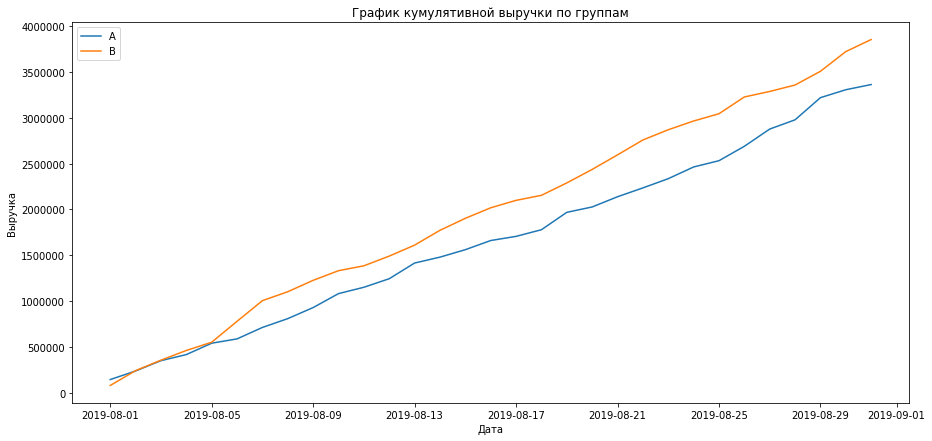

In [33]:
### График кумулятивной выручки по группам
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 7))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

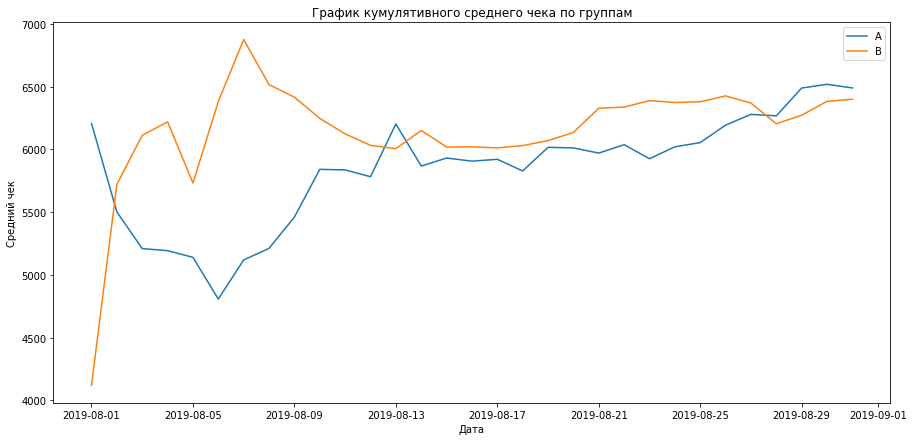

In [34]:
### График кумулятивного среднего чека
plt.figure(figsize=(15, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

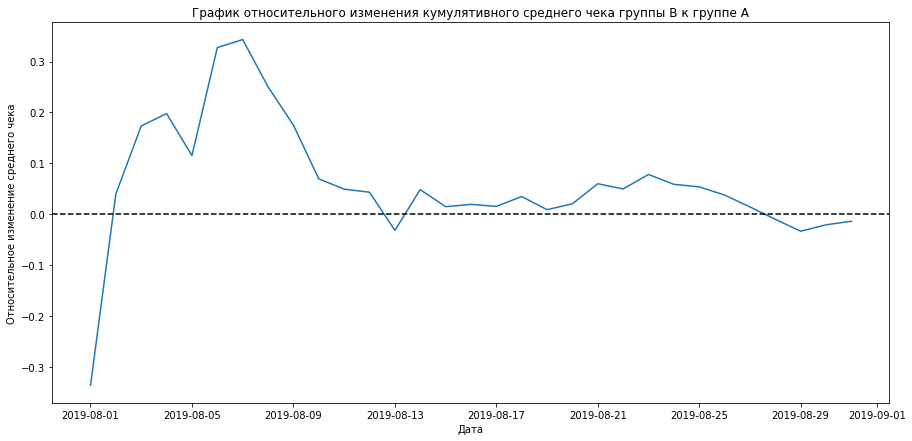

In [35]:
### График относительного изменения кумулятивного среднего чека группы B к группе A
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

plt.figure(figsize=(15, 7))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/\
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека')
plt.show()


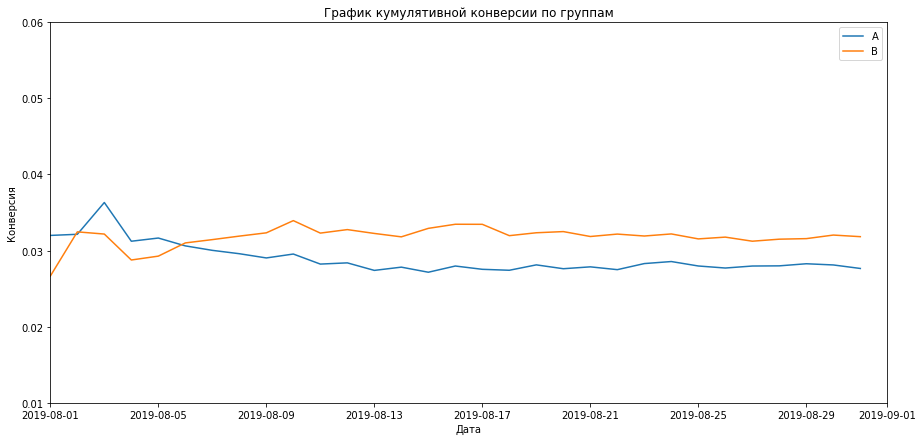

In [36]:
### График кумулятивной конверсии по группам
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 7))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0.01, 0.06]) 
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

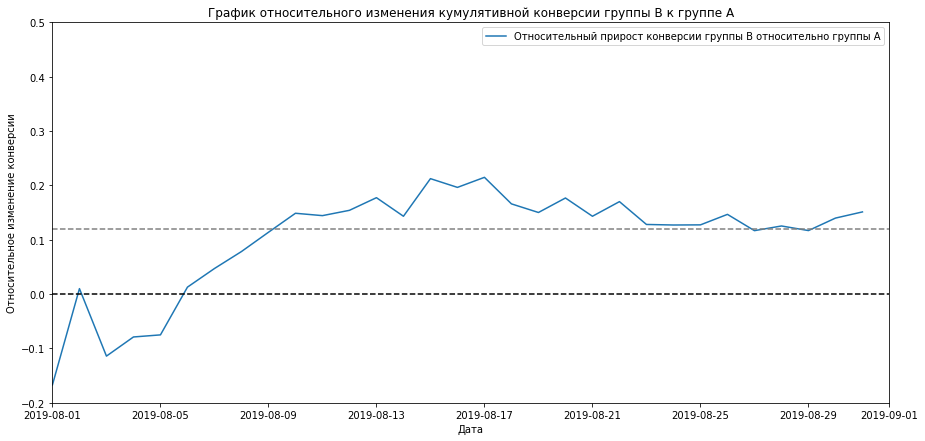

In [37]:
### График относительного изменения кумулятивной конверсии группы B к группе A
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])

# строим графики
plt.figure(figsize=(15, 7))

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.12, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.5]) 
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение конверсии')
plt.show() 

Кумулятивная выручка растет стабильно. Выше в группе B.
По динамике кумулятивного среднего чека по группам все еще сложно какой-либо вывод, так как значение даже на очищенных данных не установилось. При этом средний чек группы B в концу теста ниже группы А (возможно, было много заказов на небольшую сумму в группе B). Конверсия группы B на очищенных данных по-прежнему больше конверсии группы А.

# Вывод <a id = 'header_4'></a>

При изучении данных было обнаружено 56 пользователей, которые попали в обе группы. Следует проверить алгоритмы деления на группы.


**Приоритезация гипотез**: 

При применении двух разных фреймворков для приоритезации гипотез получили разные результаты.
В тройку лидеров и там и там попали две гипотезы: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

**Анализ A/B теста**:
* поведение пользователей в группе А и группе B различно с точки зрения конверсии: в группе B конверсия выше (и по "сырым" и по очищенным данным); 
* график различия конверсии между группами говорит о том, что результаты группы B лучше группы A
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
* По графику различия среднего чека (по "сырым" данным) сложно сделать вывод о том, что происходит. Оказывает влияние крупный заказ.
* выручка по группе B выше,чем по группе A.

Тест показывет, что между группами есть разница в конверсии, но нет разницы в среднем чеке. Возможно, 
пользователи группы B стали покупать чаще, но более дешевые продукты.

Показатель выручки вырос, показатели метрик стабилизировались. **Тест следует завершить и признать успешным.**